max_features | Accuracy | Macro F1 | Log Loss | Tree Corr
----------------------------------------------------------
          1 | 0.860    | 0.860   | 0.453   | 0.386
          3 | 0.867    | 0.867   | 0.425   | 0.524
          5 | 0.882    | 0.882   | 0.364   | 0.546
       sqrt | 0.877    | 0.877   | 0.370   | 0.535
       None | 0.853    | 0.854   | 0.444   | 0.591


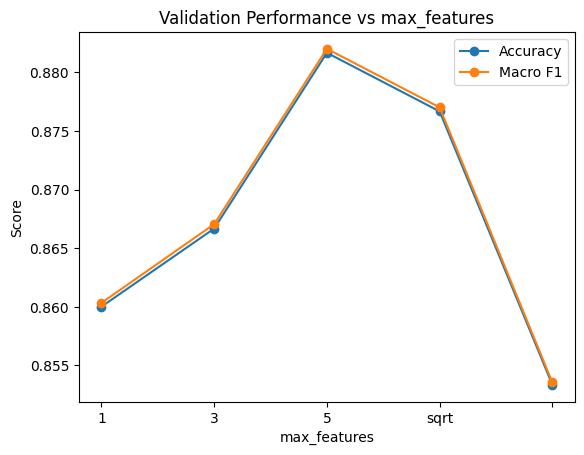

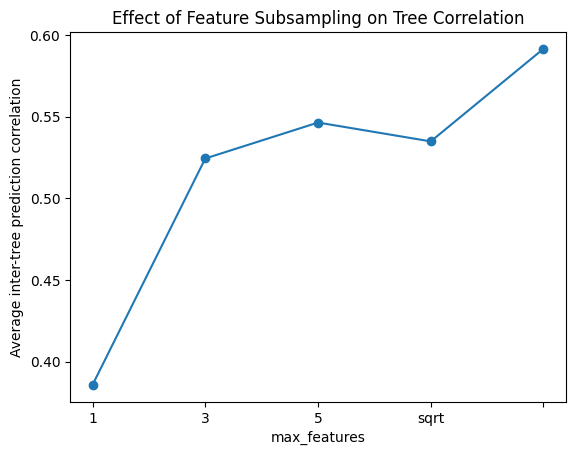

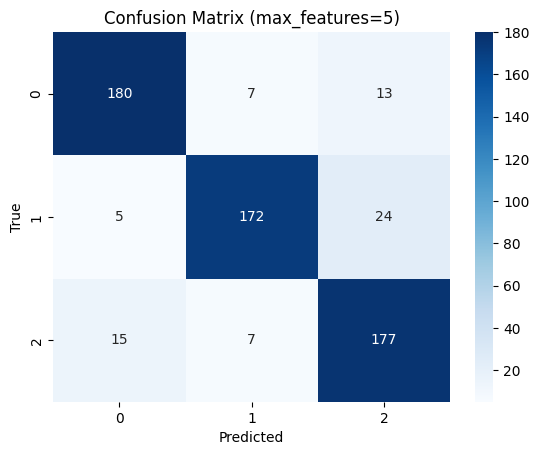

In [1]:
# =========================
# Random Forest: Effect of max_features on Correlated Features
# Single-cell, fully reproducible experiment
# =========================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix

# -------------------------
# 1. Generate synthetic dataset with correlated features
# -------------------------
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=5,
    n_redundant=10,   # induces strong feature correlation
    n_repeated=0,
    n_classes=3,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# -------------------------
# 2. Experimental setup
# -------------------------
max_features_values = [1, 3, 5, "sqrt", None]
results = []
tree_correlations = []

# -------------------------
# 3. Train and evaluate models
# -------------------------
for mf in max_features_values:
    rf = RandomForestClassifier(
        n_estimators=200,
        max_features=mf,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    loss = log_loss(y_test, y_prob)

    # Inter-tree prediction correlation
    tree_preds = np.array([tree.predict(X_test) for tree in rf.estimators_])
    corr_matrix = np.corrcoef(tree_preds)
    upper_triangle = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
    mean_corr = np.mean(upper_triangle)

    results.append((mf, acc, f1, loss))
    tree_correlations.append(mean_corr)

# -------------------------
# 4. Print results
# -------------------------
print("max_features | Accuracy | Macro F1 | Log Loss | Tree Corr")
print("----------------------------------------------------------")
for (mf, acc, f1, loss), corr in zip(results, tree_correlations):
    print(f"{str(mf):>11} | {acc:.3f}    | {f1:.3f}   | {loss:.3f}   | {corr:.3f}")

# -------------------------
# 5. Plot: Performance vs max_features
# -------------------------
accs = [r[1] for r in results]
f1s = [r[2] for r in results]

plt.figure()
plt.plot(range(len(max_features_values)), accs, marker="o", label="Accuracy")
plt.plot(range(len(max_features_values)), f1s, marker="o", label="Macro F1")
plt.xticks(range(len(max_features_values)), max_features_values)
plt.xlabel("max_features")
plt.ylabel("Score")
plt.legend()
plt.title("Validation Performance vs max_features")
plt.show()

# -------------------------
# 6. Plot: Inter-tree correlation
# -------------------------
plt.figure()
plt.plot(range(len(max_features_values)), tree_correlations, marker="o")
plt.xticks(range(len(max_features_values)), max_features_values)
plt.xlabel("max_features")
plt.ylabel("Average inter-tree prediction correlation")
plt.title("Effect of Feature Subsampling on Tree Correlation")
plt.show()

# -------------------------
# 7. Confusion matrix for best model (by Macro F1)
# -------------------------
best_idx = np.argmax(f1s)
best_mf = max_features_values[best_idx]

rf_best = RandomForestClassifier(
    n_estimators=200,
    max_features=best_mf,
    random_state=42,
    n_jobs=-1
)
rf_best.fit(X_train, y_train)

cm = confusion_matrix(y_test, rf_best.predict(X_test))

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (max_features={best_mf})")
plt.show()
